In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [29]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [30]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [31]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [32]:
# reflect an existing database into a new model
model = automap_base()
# reflect the tables
model.prepare(engine, reflect=True)

In [33]:
# View all of the classes that automap found
model.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
measurement = model.classes.measurement
station = model.classes.station

In [35]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
tripYear = 2014
temps = calc_temps('2014-01-01', '2014-12-31')
temps

[(56.0, 73.26453600308048, 85.0)]

In [38]:
dateMin, dateMax = session.query(func.min(measurement.date), func.max(measurement.date)).first()
yearRange = list(range(int(dateMin[:4])))
tmin, tavg, tmax = calc_temps(f"{tripYear}-01-01", f"{tripYear}-12-31")[0]

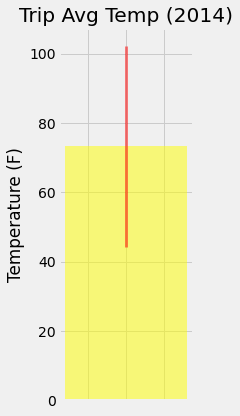

<Figure size 432x288 with 0 Axes>

In [40]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(1, 1, figsize = (3, 6))
plt.errorbar(
    x = 0,
    y = tavg,
    yerr = tmax - tmin,
    elinewidth=3,
    color = "red",
    alpha = 0.5
)

plt.bar(
    x = 0,
    height = tavg,
    color="yellow",
    alpha = 0.5
)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(''))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.title(f"Trip Avg Temp ({tripYear})")
plt.xlabel('')
plt.ylabel('')
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.savefig(f'Images/bonus_2_{tripYear}.png', bbox_inches = "tight")
plt.figure()
plt.show()

### Daily Rainfall Average

In [45]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_per_weather_station = session.query(
    func.sum(measurement.prcp), 
    station.station, 
    station.name, 
    station.latitude, 
    station.longitude, 
    station.elevation
).join(measurement, measurement.station == station.station).\
group_by(measurement.station).\
filter(
    measurement.date >= func.DATE(f"{tripYear-1}-01-01"),
    measurement.date <= func.DATE(f"{tripYear-1}-12-31")
).order_by(func.sum(measurement.prcp).desc())

for weather_station in rainfall_per_weather_station:
    prcp_sum, station, name, lat, lng, elevation = weather_station
    print(f"{round(prcp_sum, 2)}\ttotal amount of rainfall")
    print(f"\tlatitude: {round(lat, 2)}, longitude: {round(lng, 2)}, elevation: {round(elevation, 2)}")
    print(f"\tweather station: {station} - {name}")
    print()

136.8	total amount of rainfall
	latitude: 21.33, longitude: -157.8, elevation: 152.4
	weather station: USC00516128 - MANOA LYON ARBO 785.2, HI US

89.03	total amount of rainfall
	latitude: 21.45, longitude: -157.85, elevation: 32.9
	weather station: USC00519281 - WAIHEE 837.5, HI US

47.22	total amount of rainfall
	latitude: 21.42, longitude: -157.8, elevation: 14.6
	weather station: USC00513117 - KANEOHE 838.1, HI US

39.66	total amount of rainfall
	latitude: 21.34, longitude: -157.71, elevation: 19.5
	weather station: USC00519523 - WAIMANALO EXPERIMENTAL FARM, HI US

27.97	total amount of rainfall
	latitude: 21.52, longitude: -157.84, elevation: 7.0
	weather station: USC00514830 - KUALOA RANCH HEADQUARTERS 886.9, HI US

19.25	total amount of rainfall
	latitude: 21.27, longitude: -157.82, elevation: 3.0
	weather station: USC00519397 - WAIKIKI 717.2, HI US

17.69	total amount of rainfall
	latitude: 21.32, longitude: -158.0, elevation: 0.9
	weather station: USC00511918 - HONOLULU OBSERV

In [47]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [50]:
dt_format = "%Y-%m-%d"

trip_month = 7
trip_starting_day = 16
trip_length = 12

# Use the start and end date to create a range of dates
dates = [f"{trip_month:02d}-{day:02d}" for day in list(range(trip_starting_day, trip_starting_day + trip_length))]

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for day in dates:
    normals.append(daily_normals(day)[0])

# Set the start and end date of the trip
start_date = f'{tripYear}-{dates[0]}'
end_date = f'{tripYear}-{dates[-1]}'

In [53]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame({
    "date": [f"{tripYear}-{day}" for day in dates],
    "Temperature Min": [tmin for tmin, tavg, tmax in normals],
    "Temperature Average": [tavg for tmin, tavg, tmax in normals],
    "Temperature Max": [tmax for tmin, tavg, tmax in normals]
})
df["date"] = pd.to_datetime(df["date"], format=dt_format)
df.set_index("date", inplace=True)
df

,Temperature Min,Temperature Average,Temperature Max
date,,,
2014-07-16,70.0,76.344828,83.0
2014-07-17,70.0,76.301887,83.0
2014-07-18,72.0,76.637931,83.0
2014-07-19,68.0,75.890909,83.0
2014-07-20,69.0,75.462963,82.0
2014-07-21,69.0,76.924528,83.0
2014-07-22,69.0,75.788462,81.0
2014-07-23,70.0,76.203704,84.0
2014-07-24,69.0,76.555556,81.0


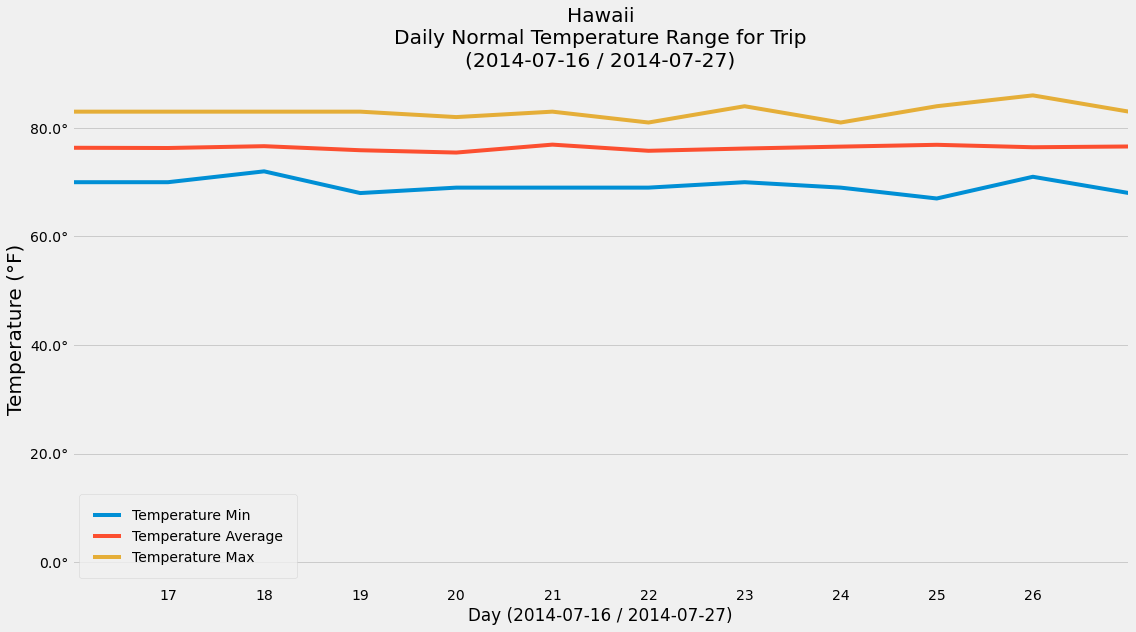

In [54]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(1, 1, figsize = (16,9))
df.plot(
    ax=ax,
    stacked=False
)
ax.fill_between(df["Temperature Max"].values, 0, alpha=1)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('')) 
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.01f}°')) 
ax.legend(
    loc='lower left', 
    borderpad =1
)
plt.title(f'Hawaii\nDaily Normal Temperature Range for Trip\n({start_date} / {end_date})')
plt.xlabel(f'Day ({start_date} / {end_date})')
plt.ylabel('Temperature (°F)', fontsize = (20))
plt.tight_layout()
plt.savefig('Images/temperature_range_for_trip.png', bbox_inches = "tight")
plt.show()

## Close Session